# Tutorial: Audio - Audio Embedding
In this tutorial we show how to apply the embedding networks to embed two different audio files.

This is for example useful to align two audios to each other e.g. with dynamic time warping
using pairwise distances in embedding space.

First we need to import a couple of standard python packages
for loading and visualizing the data.
We require additional imports later on,
but import the packages where they are applied to show how things are related.

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

# path to audio files
# (to keep the repo small we take two times the same audio here)
audio_path_1 = "audio.mp3"
audio_path_2 = "audio.mp3"

## Excerpt Embedding Network
To make working with our networks easier,
we wrap all the theano code into one retrieval class (*RetrievalWrapper*).
In addition we also import the definition file of our retrieval model (*mutopia_ccal_cont_rsz*).

In [2]:
# this class contains some convenience code for embedding computation
from audio_sheet_retrieval.retrieval_wrapper import RetrievalWrapper
# this is our retrieval model
from audio_sheet_retrieval.models import mutopia_ccal_cont_rsz as model

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K40c (CNMeM is disabled, cuDNN 5105)
 
Music21 v.4 is the last version that will support Python 2.
Please start using Python 3 instead.

Set music21.environment.UserSettings()['warnings'] = 0
to disable this message.



In [3]:
# path to network parameters
param_file = "params_all_split_mutopia_full_aug.pkl"

# initialize retrieval wrapper
embed_network = RetrievalWrapper(model, param_file, prepare_view_1=None, prepare_view_2=None)

# this are dimensions of sheet image snippet and audio excerpt
excerpt_shape = model.INPUT_SHAPE_2[1:]
print("excerpt_shape", excerpt_shape)

Building network ...
Loading model parameters from: params_all_split_mutopia_full_aug.pkl
Compiling prediction functions ...
excerpt_shape [92, 42]


## Audio Excerpt Embedding
Above we have shown how to compute image embeddings starting from an entire score image.
In this part of the notebook we explain with its counterpart, an music audio.

The first thing we need to do is to compute a spectrogram from the audio file.

In [4]:
# this is what we need to import from the madmom project
from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
from madmom.audio.filters import LogarithmicFilterbank
from madmom.audio.spectrogram import FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor
from madmom.processors import SequentialProcessor

# init signal processing as described in the paper
SAMPLE_RATE = 22050
FRAME_SIZE = 2048
FPS = 20

sig_proc = SignalProcessor(num_channels=1, sample_rate=SAMPLE_RATE)
fsig_proc = FramedSignalProcessor(frame_size=FRAME_SIZE, fps=FPS, origin='future')
spec_proc = FilteredSpectrogramProcessor(LogarithmicFilterbank, num_bands=16, fmin=30, fmax=6000)  # num_bands=24, fmin=30, fmax=8000
log_spec_proc = LogarithmicSpectrogramProcessor()
processor = SequentialProcessor([sig_proc, fsig_proc, spec_proc, log_spec_proc])

# compute spectrogram
spectrogram_1 = processor.process(audio_path_1).T
spectrogram_2 = processor.process(audio_path_2).T

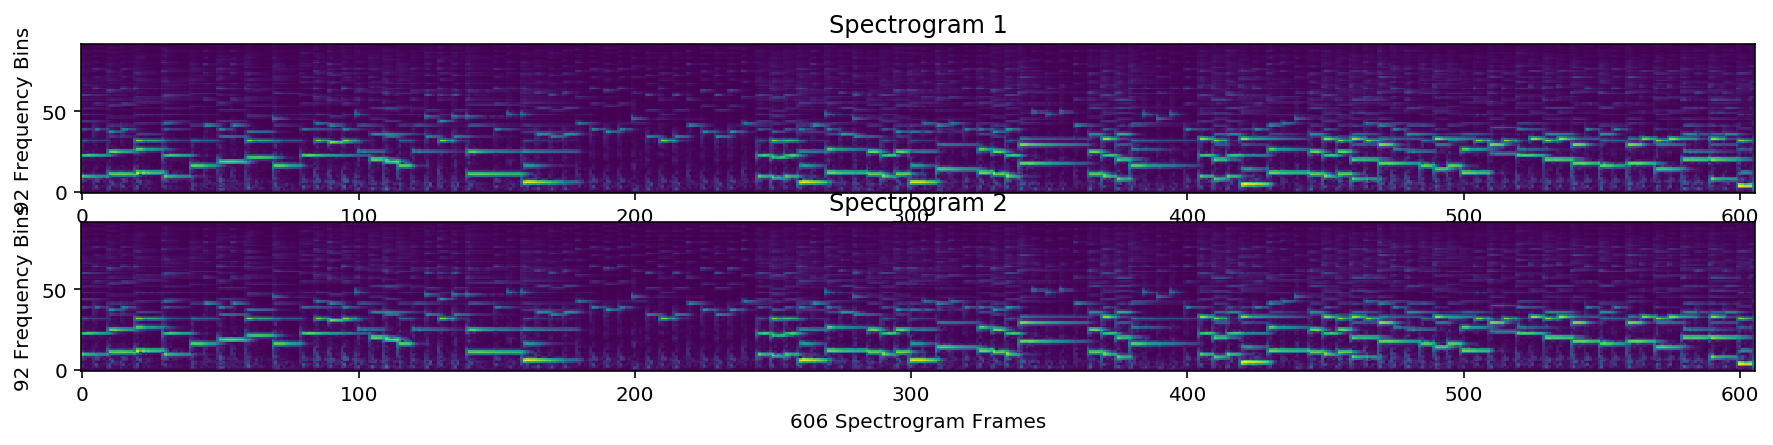

In [5]:
plt.figure("Spectrogram", figsize=(15, 3))
plt.clf()
plt.subplot(2, 1, 1)
plt.imshow(spectrogram_1, cmap="viridis", aspect="auto", origin="lower")
plt.title("Spectrogram 1")
plt.ylabel("%d Frequency Bins" % spectrogram_1.shape[0])
plt.xlabel("%d Spectrogram Frames" % spectrogram_1.shape[1])
plt.subplot(2, 1, 2)
plt.imshow(spectrogram_2, cmap="viridis", aspect="auto", origin="lower")
plt.title("Spectrogram 2")
plt.ylabel("%d Frequency Bins" % spectrogram_2.shape[0])
plt.xlabel("%d Spectrogram Frames" % spectrogram_2.shape[1])
plt.show()

Given this spectrogram we proceed as with the unrolled sheet image
by slicing it into 100 small excerpts.

In [7]:
def collect_spec_excerpts(spec):

    n_samples = 1000
    start_indices = np.linspace(start=0, stop=spec.shape[1]-excerpt_shape[1], num=n_samples)
    start_indices = start_indices.astype(np.int)

    # collect spectrogram excerpts
    spec_excerpts = np.zeros((len(start_indices), 1, excerpt_shape[0], excerpt_shape[1]), dtype=np.float32)
    for i, idx in enumerate(start_indices):
        spec_excerpts[i, 0] = spec[:, idx:idx+excerpt_shape[1]]
    
    return spec_excerpts

spec_excerpts_1 = collect_spec_excerpts(spectrogram_1)
spec_excerpts_2 = collect_spec_excerpts(spectrogram_2)
        
print("Spectrogram 1 excerpt shape", spec_excerpts_1.shape)
print("Spectrogram 2 excerpt shape", spec_excerpts_2.shape)

Spectrogram 1 excerpt shape (1000, 1, 92, 42)
Spectrogram 2 excerpt shape (1000, 1, 92, 42)


The last thing to do is to feed the spectrogram excerpts through the audio part of the encoding network
to again end up with 100 32-dimensional vectors.

In [8]:
# compute spectrogram codes
spec_codes_1 = embed_network.compute_view_2(spec_excerpts_1)
spec_codes_2 = embed_network.compute_view_2(spec_excerpts_2)
print("Spectrogram code shape", spec_codes_1.shape)
print("Spectrogram code shape", spec_codes_2.shape)

Spectrogram code shape (1000, 32)
Spectrogram code shape (1000, 32)


## Toy Application: Embedding Space Distance
To see if everything worked out we simply compute the pairwise distance between the two audio excerpt embeddings.
The image of the distance matrix below should contain a dark diagonal line of very small distances.
This could be for example the input to a nearest neighbor search or Dynamic Time Warping (DTW) in the case of alignment.

In [10]:
from sklearn.metrics.pairwise import pairwise_distances
dists = pairwise_distances(spec_codes_1, spec_codes_2)

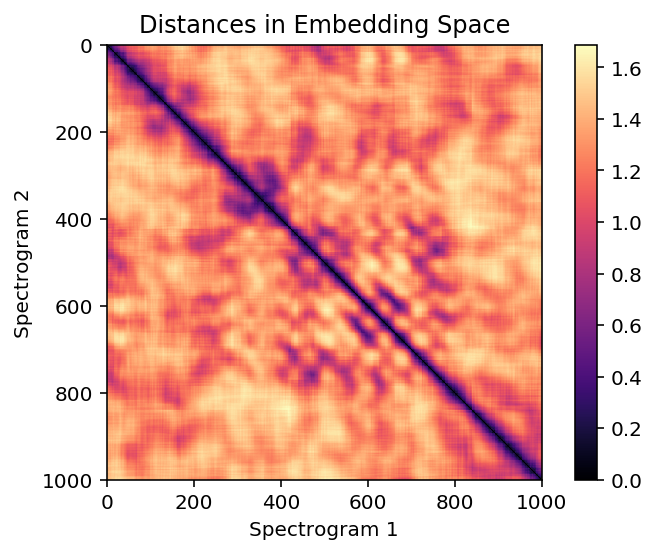

In [11]:
plt.figure("Distances")
plt.clf()
plt.imshow(dists, cmap="magma", interpolation="nearest")
plt.title("Distances in Embedding Space")
plt.xlabel("Spectrogram 1")
plt.ylabel("Spectrogram 2")
plt.colorbar()
plt.show()